##### Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
import multiprocessing as mp

### Oppgave 1

##### 1a)
Write a function that takes as input the grid size, N , and the number of monomers
we wish to consider M . The function should return a grid with the monomers placed
randomly. Monomers can only be placed in the solvent, not on top of other monomers.
Check that the grid has 2M non-zero values. M of these values represent positively
charged monomers, the other M represent negatively charged monomers.

In [2]:
def setup_monomers(N, M):
    """
    Lager et 2d-grid med positive og negative monomers.
    N: grid size
    M: monomers
    """
    #sampler "monomers"
    indexes = np.arange(0, N*N, 1).tolist() #må være liste for at sample skal fungere
    samples = random.sample(indexes, 2*M) #sample() sørger for at det ikke blir skapt duplikater.
    charges = np.concatenate((np.arange(-M, -0), np.arange(1, M+1))) #charges: -20, -19, ..., -1, 1, ..., 19, 20
    random.shuffle(charges) #shuffler ladningene
    
    locations = [] #en liste med indexer til hvor monomer eksisterer i grid.

    #lager grid
    grid = np.zeros((N, N)) #tomt grid

    for j in range(len(samples)): 
        samp_index = samples[j] #sample index (fra 1d samples)
        index = (samp_index // N, samp_index % N) #1D -> 2D index
        grid[index] = charges[j] #legger til ladingen
        locations.append(index)
        
    return grid, locations

In [3]:
N = 15 #bredden på universet
M = 25 #antall positive/negative monomers

universe, monomers = setup_monomers(N,M) #creating the universe

print("grid size: ", universe.shape)
print("Number of grid elements: ", universe.shape[0] * universe.shape[1])
print("Number of zero elements:", universe.shape[0] * universe.shape[1] - len(monomers))
print("Number of non-zero elements:", len(monomers), " = ", np.count_nonzero(universe))

grid size:  (15, 15)
Number of grid elements:  225
Number of zero elements: 175
Number of non-zero elements: 50  =  50


##### 1b)
Use plt.pcolormesh (or a similiar function) to visualize a system with grid
size N . Include a figure of the system you created in 1a). It should be clear from
the figure what N and M you have chosen. Tip: If you decide to use the function
plt.pcolormesh , you might notice that the rows are interchanged in the plot and in
matrix form. An easy fix for this is to use grid[::-1,] as input to plt.pcolormesh 

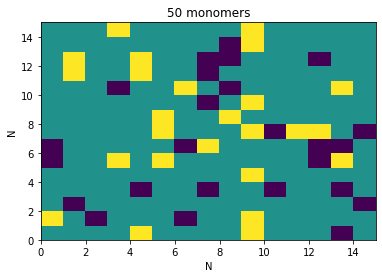

In [4]:
def plot_grid(grid):
    plt.pcolormesh(grid, vmin = -1, vmax = 1)
    N = grid.shape[0]
    M = np.count_nonzero(grid)
    plt.xlabel(f"N")
    plt.ylabel(f"N")
    plt.title(f"{M} monomers")
    plt.show()

plot_grid(universe)

##### 1c)
Write a function that takes the size of the grid N , and the matrix indices i and j
as input, and returns an array containing the coordinates of the four nearest neighbors.
Remember to account for the periodic boundary conditions as described in subsection
2.3

In [5]:
def neighbours(N, i, j):
    """
    returns a list containing four neighbours.
    Assumes quadratic grid.
    
    Tror dette funker siden i er 1-indeksert nummer på kollonne, 
    og j er samme for rad. Virker tungvint men har sikkert noe med grensetilfeller å gjøre...
    """
    left_i = (i - 1 + N) % N 
    right_i = (i + 1) % N
    above_j = (j - 1 + N) % N
    below_j = (j + 1) % N

    return [[left_i, j], [i, above_j], [right_i, j],[i, below_j]]

##### 1d)
Write a function that takes the grid as input, and returns the total energy of the
system. Tip: For all monomers, use equation (4) to calculate the energy between the
monomer and all of its nearest neighbors. The energy of the system is the sum of all
the monomer energies (divided by some integer that account for the overcounting of
interactions). You may introduce a dimensionless quantity E/α if you wish. Calculate
the energy of the grid you presented in 1b).


In [6]:
def total_energy(grid):
    """
    Søker gjennom monomene og summerer opp energien til systemet. 
    Regner ut energien for hvert NN par.
    
    pairs er en liste med alle nabo-monomer parene som algoritmen regner ut energien for.
    (bool) calculated_pair sørger for at vi ikke regner ut to ganger per par.
    
    """
    e = 1.6e-19 #elementær ladning
    e_r = 78 #relative permitivity
    e_0 = 8.854188e-12 #elektrisk permitivitet
    a = 23e-6 #avstand mellom monomene
    
    alpha = e**2 / (4 * np.pi * e_0 * e_r * a**2)
    
    E = 0 #init
    
    N = grid.shape[0]
    monomers = np.transpose(np.nonzero(grid)) #returns a list with indexes corresponding to monomers
    pairs = []

    for monomer in monomers:
        this = grid[monomer[0], monomer[1]]
        for neighbour in neighbours(N, monomer[0], monomer[1]):
            #sjekker om nabo-monomer paret allerede er beregnet for.
            pair = [monomer.tolist(), neighbour]
            reversed_pair = [pair[1], pair[0]]

            calculated_pair = (pair in pairs) or (reversed_pair in pairs) #true if already calculated.
            
            if(grid[neighbour[0], neighbour[1]] != 0.0 and not calculated_pair):
                pairs.append(pair)
                E += alpha * np.sign(this * grid[neighbour[0], neighbour[1]]) #regner ut.
                
    return E

##### 1e)
Implement the Monte Carlo algorithm described in Algorithm 2. The input pa-
rameters should be the number of Monte Carlo steps in the simulation, Ns, as well as N ,
M , T and any other parameters you find necessary. It will be convenient to also have a
grid as an argument to the function. This grid is the initial system configuration before
the simulation starts. For monomer-systems, the only illegal move is trying to move a
monomer on top of another monomer.

In [7]:
from tqdm import tqdm

def MC(Ns, T, init_grid):
    """
    Monte carlo.

    Simulerer systemet ved bruk av tilfeldige valg. 
    Et tilfeldig monomer blir valgt og beveger seg i en tilfeldig retning. Dette blir enten tolket som 
    en termisk vibrasjon eller en bevegelse mot en lavere system energi.
    """
    t = time.time() #tid

    k_b = 1.38e-23
    beta = 1 / (k_b * T)
    eV = 1.602176634e-19
    
    count = [0, 0, 0] #teller hvor MC havner, i "if", "elif" eller "else"
    
    N = init_grid.shape[0] #størrelsen på grid
    M = np.count_nonzero(init_grid) / 2 #antall positive/negative ladninger
    
    print("starting simulation [ T =",T,"K, Ns =",Ns,", M =",M,", N =",N, "]")

    grid = init_grid

    monomers = np.transpose(np.nonzero(grid)) #gir indexer til ikke-negative ruter i grid. Aka, monomer 
    
    energies = [total_energy(grid)] #liste som holder på utviklingen av energi
    print("initial energy: ", energies[-1] / eV, "eV")
    n = 0

    for it in tqdm(range(Ns)):

        prev_grid = grid.copy()
        prev_monomers = monomers.copy()

        #gjør tilfeldige valg:
        rand_monomer_index = round(np.random.uniform(0, len(monomers)-1)) #velger en random monomer index
        prev_monomer = monomers[rand_monomer_index] #tilfeldig monomer index til grid.
        
        rand_neighbour_index = round(np.random.uniform(0, 3)) #velger en av 4 naboer
        new_monomer = neighbours(N, prev_monomer[0], prev_monomer[1])[rand_neighbour_index] #flyttet til naboposisjon.
        
        illegalMove = (grid[new_monomer[0], new_monomer[1]] != 0) #monomene kan kun bevege seg til et tomt område
        
        if illegalMove:
            continue #prøver på nytt. 
            #continue gjør at vi begynner på ny i loopen, og det som kommer etterpå blir da ikke gjort.
        
        #oppdaterer grid og monomer listen
        prev_index = (prev_monomer[0], prev_monomer[1])
        new_index = (new_monomer[0], new_monomer[1])

        charge = grid[prev_index] 
        grid[prev_index] = 0
        grid[new_index] = charge
        monomers[rand_monomer_index] = new_monomer

        new_energy = total_energy(grid) #energien til systemet etter grid er oppdatert
        
        
        if new_energy <= energies[-1]: 
            energies.append(new_energy)
            count[0] += 1
            #endringen er akseptert

        elif random.uniform(0, 1) < np.exp(-beta * (new_energy - energies[-1])): #termisk bevegelse, elns. np.exp(-beta * (new_energy - energies[-1]))
            energies.append(new_energy)
            count[1] += 1
            #endringen er akseptert som resultat av termisk vibrasjon

        else:
            #endringen er ikke akseptert. Grid og monomer blir tilbakesatt til slik de var og energien er uforandret.
            grid = prev_grid 
            monomers = prev_monomers
            energies.append(energies[-1]) #energien til systemet  er ikke endret
            count[2] += 1
            
    
        #n += 1
        #if(it/Ns % 0.1 == 0):
        #    # "gjetter" hvor mye tid som er igjen
        #    print(it/Ns * 100, "% ~", round(((time.time()-t) / n) * (Ns - it)), "seconds remaining.", "system energy: ", energies[-1] / eV, "eV")
        #    t = time.time()
        #    n = 0
   # print("100% ~ 0 seconds remaining. system energy: ", energies[-1])
    
    
    return grid, [e / eV for e in energies], count

##### 1f)
Run two simulations, both with, Ns = 50000, N = 15 and M = 25, but with
differing T . Use T = 200 K and T = 500 K. We note that while such temperature
variations are not realistic from a biological point of view, it is still interesting to consider
its impact. After the last MC step is complete, save the grid configuration from the low
T simulation (Using e.g. np.savez ). Plot how the energy develops as a function of t for
both simulations in the same figure. Determine visually how many MC steps are needed
for the system to reach its equilibrium2 for the two temperatures. We denote this value
as tequil. Explain why tequil is different for the two temperatures. Hint: You might want
to relate this to the concept of local energy minima.

Simulating two simulations with T = 200K and T = 500K:

In [ ]:
T1 = 200 #k
T2 = 500 #k

Ns = 50000

M = 25
N = 15

init = setup_monomers(N, M)[0]

Ikke kjør blokken under ofte. Tar en del tid.

In [9]:
t0 = time.time()

data = [(Ns, T1, init), (Ns, T2, init)] #two configs.

pool = mp.Pool(mp.cpu_count()) #for parallell processing
output = pool.starmap(MC, data) #simulating two simulations using multiprocessing

t1 = time.time()
print(f"runtime = {round(t1-t0)} seconds")

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(1, 2)

objects = ("if", "elif", "else")
y_pos = np.arange(len(objects))

axs[0].set_title(f"T = {T1}")
axs[1].set_title(f"T = {T2}")
axs[0].bar(y_pos, output[0][2], align='center', alpha=0.5)
axs[1].bar(y_pos, output[1][2], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
fig.tight_layout(pad=3.0)

In [ ]:
fig, axs = plt.subplots(3, 2, figsize = (10, 10))
axs[0][0].pcolormesh(init, vmin = -1, vmax = 1)
axs[0][0].set_title(f"Initial system. T = {T1}K")
axs[0][1].pcolormesh(init, vmin = -1, vmax = 1)
axs[0][1].set_title(f"Initial system. T = {T2}K")
axs[1][0].pcolormesh(output[0][0], vmin = -1, vmax = 1)
axs[1][0].set_title(f"T = {T1}K. System after {Ns} iterations")
axs[1][1].pcolormesh(output[1][0], vmin = -1, vmax = 1)
axs[1][1].set_title(f"T = {T2}K. System after {Ns} iterations")
axs[2][0].plot(np.arange(0, len(output[0][1]), 1), output[0][1])
axs[2][0].set_title(f"Energy development during iterations. T = {T1}")
axs[2][1].plot(np.arange(0, len(output[1][1]), 1), output[1][1])
axs[2][1].set_title(f"Energy development during iterations. T = {T2}")
fig.tight_layout(pad=3.0)

##### 1g)
Write a function that takes a grid as input, and returns the corresponding cluster
grid. Hint: Using recursion in combination with the function you wrote in 1c) may be a
good idea here. Use the data you saved in 1f ) to visualize the grid and the corresponding
cluster grid side-by-side (i.e. a similar figure to Figure 4).

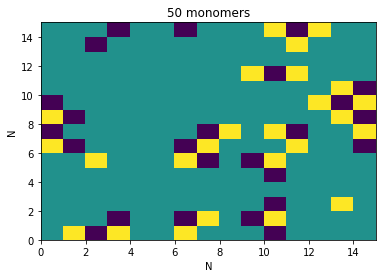

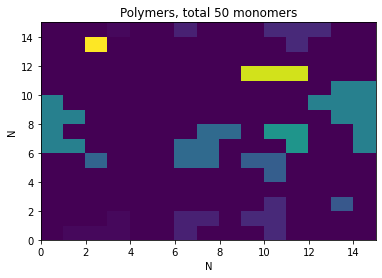

In [ ]:
from pprint import pprint

class Monomer:
    def __init__(self, position):
        self.position = position
        self.checked = False
        self.neighbours = []
        self.number = 0
    
    def set_neighbour(self, neighbour):
        if neighbour.position not in [n.position for n in self.neighbours]:
            self.neighbours.append(neighbour)
    
    def give_number(self, number):
        if not self.checked:
            self.checked = True
            self.number = number
            for neighbour in self.neighbours:
                neighbour.give_number(number)
    
    def __str__(self):
        return f"{self.position}, number={self.number},"

    def __repr__(self):
        return self.__str__()

def occupied_neighbours(grid, monomer: "Monomer", all_monomers: "list[Monomer]"):
    acutal_neighbours = []
    all_neighbours = list(tuple(coordinate) for coordinate in neighbours(grid.shape[0], *monomer.position))
    for potential_monomer in all_monomers:
        if potential_monomer.position in all_neighbours:
            acutal_neighbours.append(potential_monomer)

    return acutal_neighbours

def cluster_grid(grid):
    monomers =  np.transpose(np.nonzero(grid))
    monomers = [Monomer(tuple(monomer)) for monomer in monomers]
    new_grid = grid.copy()
    number = 1
    for monomer in monomers:
        neighbours = occupied_neighbours(grid, monomer, monomers)
        for neighbour in neighbours:
            monomer.set_neighbour(neighbour)
    for monomer in monomers:
        monomer.give_number(number)
        number += 1
        
    for monomer in monomers:
        new_grid[monomer.position[0], monomer.position[1]] = monomer.number
     
    
    
    return new_grid

def plot_cluster(grid): #Function for plotting a mesh whith color gradient
    plt.pcolormesh(grid) 
    N = grid.shape[0]
    M = np.count_nonzero(grid)
    plt.xlabel(f"N")
    plt.ylabel(f"N")
    plt.title(f"Polymers, total {M} monomers")
    plt.show()


clustered = cluster_grid(output[0][0])
plot_grid(output[0][0])
#print(clustered) #Shows the numbervalue representing each polymer
plot_cluster(clustered) 

In [ ]:
from matplotlib.colors import to_rgb


a = [[1,1,0,2],[0,1,2,3],[1,0,5,2],[1,2,3,4]]
N = 15 # dimention
M = 25 #monomers
n = 40 #amount of polymers

def meanClusterSize(clusterGrid):
    clusterList = []
    clusterList = np.concatenate(clusterGrid)
    polSizes = np.zeros(np.nanmax(clusterList) + 1)
    nr = 1
    for j in range(len(polSizes)):
        for i in range(len(clusterList)):
            if(clusterList[i] == nr):
                polSizes[nr] += 1
            else: continue
        nr +=1
    tot = 0
    for i in range(len(polSizes)):
        tot += polSizes[i]
    d = tot/(len(polSizes)-1)
    return polSizes, tot, d #Returnerer array med de ulike polymerene gitt ved deres lengder, totalt antall monomere og gjennomsnittlig lengde på polymer; d.


print(meanClusterSize(a))
    
T_l = 100
T_h = 1000
TT = np.linspace(T_l, T_h, 10)
t_max = 100000
s = 1/200
C = 10000
t_r = 1000


def t_equil(T):
    tx = t_max * np.exp(-s * (T - T_l)) + C
    return tx
print(TT)
print(t_equil(TT))



n_samples = 10
Ns = t_equil(T) + n * t_r

def MC_equil(Ns, T, init_grid):
    """
    Monte carlo.

    Simulerer systemet ved bruk av tilfeldige valg. 
    Et tilfeldig monomer blir valgt og beveger seg i en tilfeldig retning. Dette blir enten tolket som 
    en termisk vibrasjon eller en bevegelse mot en lavere system energi.
    """
    t = time.time() #tid

    k_b = 1.38e-23
    beta = 1 / (k_b * T)
    eV = 1.602176634e-19
    
    count = [0, 0, 0] #teller hvor MC havner, i "if", "elif" eller "else"
    
    N = init_grid.shape[0] #størrelsen på grid
    M = np.count_nonzero(init_grid) / 2 #antall positive/negative ladninger
    t_e = t_equil(T) + n_samples * t_r

    print("starting simulation [ T =",T,"K, Ns =",Ns,", M =",M,", N =",N, "]")

    grid = init_grid

    monomers = np.transpose(np.nonzero(grid)) #gir indexer til ikke-negative ruter i grid. Aka, monomer 
    
    energies = [total_energy(grid)] #liste som holder på utviklingen av energi
    print("initial energy: ", energies[-1] / eV, "eV")
    n = 0

    samples = []

    for it in tqdm(range(Ns)):

        prev_grid = grid.copy()
        prev_monomers = monomers.copy()

        #gjør tilfeldige valg:
        rand_monomer_index = round(np.random.uniform(0, len(monomers)-1)) #velger en random monomer index
        prev_monomer = monomers[rand_monomer_index] #tilfeldig monomer index til grid.
        
        rand_neighbour_index = round(np.random.uniform(0, 3)) #velger en av 4 naboer
        new_monomer = neighbours(N, prev_monomer[0], prev_monomer[1])[rand_neighbour_index] #flyttet til naboposisjon.
        
        illegalMove = (grid[new_monomer[0], new_monomer[1]] != 0) #monomene kan kun bevege seg til et tomt område
        
        if illegalMove:
            continue #prøver på nytt. 
            #continue gjør at vi begynner på ny i loopen, og det som kommer etterpå blir da ikke gjort.
        
        #oppdaterer grid og monomer listen
        prev_index = (prev_monomer[0], prev_monomer[1])
        new_index = (new_monomer[0], new_monomer[1])

        charge = grid[prev_index] 
        grid[prev_index] = 0
        grid[new_index] = charge
        monomers[rand_monomer_index] = new_monomer

        new_energy = total_energy(grid) #energien til systemet etter grid er oppdatert
        
        
        if new_energy <= energies[-1]: 
            energies.append(new_energy)
            count[0] += 1
            #endringen er akseptert

        elif random.uniform(0, 1) < np.exp(-beta * (new_energy - energies[-1])): #termisk bevegelse, elns. np.exp(-beta * (new_energy - energies[-1]))
            energies.append(new_energy)
            count[1] += 1
            #endringen er akseptert som resultat av termisk vibrasjon

        else:
            #endringen er ikke akseptert. Grid og monomer blir tilbakesatt til slik de var og energien er uforandret.
            grid = prev_grid 
            monomers = prev_monomers
            energies.append(energies[-1]) #energien til systemet  er ikke endret
            count[2] += 1
        
        if(it >= t_e and it%1000 == 0):
            samples.append(grid)
        else: continue
    
        #n += 1
        #if(it/Ns % 0.1 == 0):
        #    # "gjetter" hvor mye tid som er igjen
        #    print(it/Ns * 100, "% ~", round(((time.time()-t) / n) * (Ns - it)), "seconds remaining.", "system energy: ", energies[-1] / eV, "eV")
        #    t = time.time()
        #    n = 0
   # print("100% ~ 0 seconds remaining. system energy: ", energies[-1])
    
    
    return grid, [e / eV for e in energies], count, 

init = setup_monomers(N, M)[0]

test = MC_equil(int(Ns[0]), 300, init)[3] 
print(test)
    #input_data = [(N, T, setup_monomers(N, M)) for T in TT]

(array([0., 5., 4., 2., 1., 1.]), 13.0, 2.6)
[ 100.  200.  300.  400.  500.  600.  700.  800.  900. 1000.]
[110000.          70653.06597126  46787.94411714  32313.01601484
  23533.52832366  18208.49986239  14978.70683679  13019.73834223
  11831.56388887  11110.89965382]
starting simulation [ T = 300 K, Ns = 150000 , M = 25.0 , N = 15 ]
initial energy:  0.20881992918335263 eV


 18%|█▊        | 26379/150000 [00:30<02:22, 866.94it/s]

##### 1h)
Plot ⟨d⟩ as a function of T . Why is ⟨d⟩ larger at small T ? Discuss if your choice
of n will yield reliable results. Are any of your results surprising? In order to observe
how the initial conditions of the grid affects the clustering size, redo the simulation,
and compare the results of the two simulations. Why is the discrepancy between the
simulations larger at lower temperatures?

In [ ]:

t0 = time.time()

pool = mp.Pool(mp.cpu_count()) #for parallell processing
output_1h = pool.starmap(MC, input_data) #simulating two simulations using multiprocessing

t1 = time.time()
print(f"runtime = {round(t1-t0)} seconds")

AttributeError: ignored

### Oppgave 2

##### 2a)
Write a similar function as you did in 1a), but now you should also take the
multivalency L as input. This is an extension of Algorithm 1 where you place M posi-
tively and M negatively charged polymers. The function should return a grid with 2M
polymers, each with multivalency L. Include a figure of a system with L > 20

In [ ]:
def setup_polymers(N, M, L):
    grid = np.zeros((N, N))

    indexes = np.arange(0, N*N, 1).tolist() #må være liste for at sample skal fungere
    samples = random.sample(indexes, 2*M) #sample() sørger for at det ikke blir skapt duplikater.
    charges = np.concatenate(([-1 for _ in range(M)], [1 for _ in range(M)]))
    random.shuffle(charges) #shuffler ladningene

    for i, charge in enumerate(charges):
        index = (samples[i] // N, samples[i] % N) #random 2D index

        posArr = [] #monomer position array
        posArr.append([index[0], index[1]])
        
        for j in range(1, L):
            randomIndex = round(np.random.uniform(0, len(posArr)-1))
            
            randMonomer = posArr[randomIndex]
            neighbouring_indexes = neighbours(N, randMonomer[0], randMonomer[1])
            neighbouring_charges = [grid[int(n[0]), int(n[1])] for n in neighbouring_indexes]
            nonzero_neighbours = [neighbouring_indexes[i[0]] for i in np.transpose(np.nonzero(neighbouring_charges))]

            for k, element in enumerate(nonzero_neighbours):
                if element == []:
                    nonzero_neighbours.pop(k)


            if len(nonzero_neighbours) == len(neighbouring_indexes):
                continue #all neighbours are monomers and ocupied.
          
            random_neighbour = neighbouring_indexes[round(np.random.uniform(0, len(neighbouring_indexes)-1))]
            
            if random_neighbour in nonzero_neighbours:
                continue
            
            grid[int(random_neighbour[0]), int(random_neighbour[1])] = charge
            posArr.append(random_neighbour)

            j+=1
        
    return grid

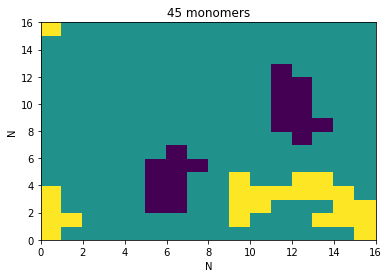

In [ ]:
poly_grid = setup_polymers(16, 2, 20)
plot_grid(poly_grid)

##### 2b)
Extend the energy function you wrote in exercise 1d), so it can calculate the
energy of polymer-systems. As mentioned in the introduction, covalent bonds bind
monomers within the same polymer, thus, for simplicity, you may put interactions be-
tween monomers belonging to the same polymer to zero.

In [10]:
class Polymer: 
    def __init__(self, monomers): #Tar inn en liste med monomerer som utgjør polynomet
        self.monomers = [Monomer(tuple(monomer)) for monomer in monomers] #Liste med alle inngående monomerer
        self.charge = 0
        self.checked = False 
        self.size = len(monomers)
        self.neighbours = [] #liste med alle monomerer som er nabo med polymeret
    
    def outside_neigbours(self):
        for monomer in self.monomers:
            for neighbour in monomer.neighbours:
                if neighbour not in self.monomers:
                    self.neighbours.append(neighbour)
        return self.neighbours

    def set_charge(self, charge):
        self.charge = charge
  
    def update_polymer_number(self, grid):
        for monomer in self.monomers: 
            grid[monomer[0]][monomer[1]] = self.charge
        return grid 
    
    def checked_polymer(self):
        self.checked = True

#@jit(nopython=True)
def total_energy_plymer(grid, polymers):
    e = 1.6e-19 #elementær ladning
    e_r = 78 #relative permitivity
    e_0 = 8.854188e-12 #elektrisk permitivitet
    a = 23e-6 #avstand mellom monomene
    
    alpha = e**2 / (4 * np.pi * e_0 * e_r * a**2)
    
    E = 0 #init
    
    N = grid.shape[0]
    
    #Making sure every monomer is marked as not checked 
    for polymer in polymers:
      for monomer in polymer.monomers:
        monomer.checked = False

    for polymer in polymers:
        polymer.charge = grid[polymer.monomers[0].position[0]][polymer.monomers[0].position[1]]
        for monomer in polymer.monomers: #Marks every monomer in the polymer as checked. These monomers will not contribute more to the energy
          monomer.checked = True

        for neighbour in polymer.neighbours:
            #Sjekker at vi ikke har gjort rede for naboparet: 
            if not neighbour.checked:
              E += alpha * np.sign(polymer.charge * grid[neighbour[0], neighbour[1]])
                
    return E


print(total_energy_plymer(poly_grid, polymers))

NameError: name 'poly_grid' is not defined

##### 2c)
Implement a function that rigidly moves an input-specified polymer in an input-
specified direction. In order to specify direction, one possible choice is to specify the
direction by integers: [Right, Left, Up, Down] ⇐⇒ [0, 1, 2, 3].

In [ ]:
def move_polymer(grid, polymer, direction): #Direction = 0,1,2,3 = right, left, up, down
    N = grid.shape[0]
    new_grid = grid.copy()

    #removing the old polymer from new_grid
    for monomer in polymer.monomers: 
        new_grid[monomer.position[0]][monomer.position[1]] = 0

    if direction == 0:   #Right
        for monomer in polymer.monomers:
            if [monomer.position[0],(monomer.position[1]-1)%N] in polymer.neighbours: #cheking if any of the new moves cross a neighbour 
                return grid                             #If move is not valid, return grid without any change
        for monomer in polymer.monomers:
            old_pos = monomer.position
            new_pos = [old_pos[0],(old_pos[1]-1)%N]
            monomer.position = new_pos #giving monomer new pos
            #updating grid: 
            new_grid[new_pos[0]][new_pos[1]] = polymer.charge

    if direction == 1:   #Left
        for monomer in polymer.monomers:
            if [monomer.position[0],(monomer.position[1]+1)%N] in polymer.neighbours: #cheking if any of the new moves cross a neighbour 
                return grid                             #If move is not valid, return grid without any change
        for monomer in polymer.monomers:
            old_pos = monomer.position
            new_pos = [old_pos[0],(old_pos[1]+1)%N]
            monomer.position = new_pos #giving monomer new pos
            #updating grid: 
            new_grid[new_pos[0]][new_pos[1]] = polymer.charge

    if direction == 2:   #Up
        for monomer in polymer.monomers:
            if [(monomer.position[0]+1)%N,monomer.position[1]] in polymer.neighbours: #cheking if any of the new moves cross a neighbour 
                return grid                             #If move is not valid, return grid without any change
        for monomer in polymer.monomers:
            old_pos = monomer.position
            new_pos = [(old_pos[0]+1)%N,old_pos[1]]
            monomer.position = new_pos #giving monomer new pos
            #updating grid: 
            new_grid[new_pos[0]][new_pos[1]] = polymer.charge

    if direction == 3:   #down
        for monomer in polymer.monomers:
            if [(monomer.position[0]-1)%N,monomer.position[1]] in polymer.neighbours: #cheking if any of the new moves cross a neighbour 
                return grid                             #If move is not valid, return grid without any change
        for monomer in polymer.monomers:
            old_pos = monomer.position
            new_pos = [(old_pos[0]-1)%N,old_pos[1]]
            monomer.position = new_pos #giving monomer new pos
            #updating grid: 
            new_grid[new_pos[0]][new_pos[1]] = polymer.charge




    return new_grid

##### 2d)
Implement Algorithm 2 and use it to run a Monte Carlo simulation of a system
with L > 10, 2 < M < 6, T = 200 K. Choose N freely, and use the rigid move from
2c) to move the polymers. Include a figure of the grid after 30000 MC steps. Comment
on why the system looks the way it does. Explain, using both quantitative results from
your simulation and from an “algorithmic” point of view, how and why the run time
requirements have changed in comparison with the monomer-systems you studied in
exercise 1). Tip: It might be convenient to have the function that moves the polymers
as an optional argument to the Monte Carlo function. In this way, you can reuse your
MC function when you introduce new move functions.

##### 2e)
Implement the medium flexibility move. Tip: It might be useful to do this exercise
in tandem with 2f ).

##### 2f)
Write a function that checks if a polymer is broken. Hint: This function will be
almost identical to the one you wrote in exercise 1g). Improve your implementation of
the medium flexibility move, such that it checks if the polymer is broken after the move
is completed. If it is broken, the function should instead return the original grid (i.e.
the grid where the polymer is not moved).

##### 2g)
Redo the simulation in exercise 2d) with the same parameters, but using the
medium flexible move. Compare the grid produced with flexible polymers to the one
you presented in 2d). Plot the energy as a function of MC steps from the two simulations,
and comment on your results. How does the energy of the system relate to the physical
placement of the polymers?